# Сlustering

В этом задании мы попрактикуемся в методах снижения размерности и кластеризации данных. 

Мы будем работать с набором данных Samsung Human Activity Recognition. Скачайте данные по ссылке https://yadi.sk/d/_WFxgSIuBF06Rg. Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3, также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [42]:
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [43]:
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)

In [44]:
X_train.shape
y_test.shape

(2947,)

Для кластеризации нам не нужен вектор ответов. Объедините обучающую и тестовую выборки.

In [45]:
#your code here
X = np.concatenate((X_train, X_test), axis=0)
y =np.concatenate((y_train, y_test), axis=0)

In [46]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

Эти метки соответствуют:

1 - ходьбе,
2 - подъему вверх по лестнице,
3 - спуску по лестнице,
4 - сидению,
5 - стоянию,
6 - лежанию

Отмасштабируйте выборку с помощью StandardScaler.

In [47]:
#your code here
scaler = StandardScaler()
X_scaled =scaler.fit_transform(X)

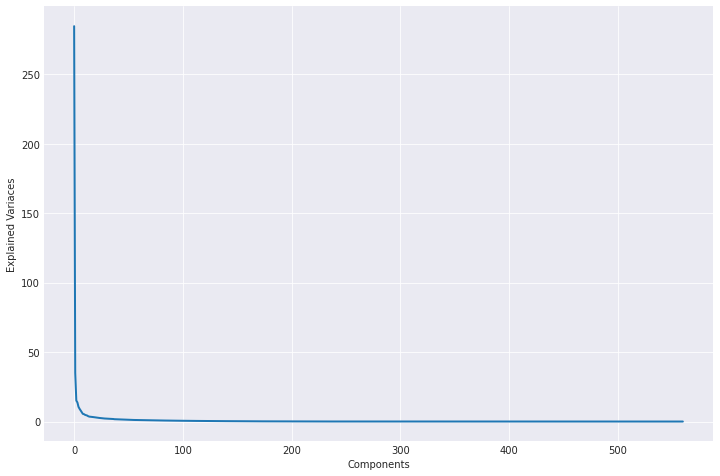

In [48]:
pca=PCA()
pca.fit(X_scaled)

plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state.

In [49]:
n_components=75

In [50]:
X_scaled_centered = X_scaled - X_scaled.mean(axis=0)

pca=PCA(n_components=n_components, whiten=True)
pca.fit_transform(X_scaled_centered)
X_pca = X_scaled_centered.copy()

Визуализируйте данные в проекции на первые две главные компоненты.

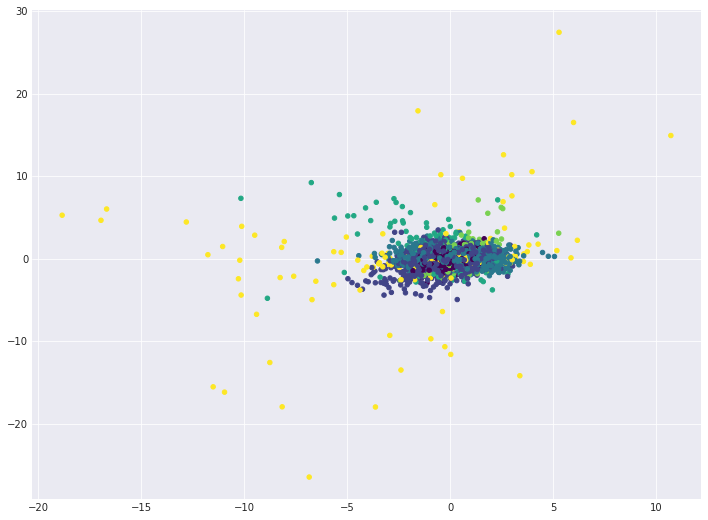

In [51]:
#your code here
plt.scatter(X_scaled_centered[:, 0],X_scaled_centered[:, 1] , c=y, s=20, cmap='viridis');

Сделайте кластеризацию данных методом KMeans, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае нужно искать 6 кластеров (так как у нас 6 классов).

Параметры:

n_clusters = n_classes (число уникальных меток целевого класса)

n_init = 100

random_state = RANDOM_STATE (для воспроизводимости результата)

In [14]:
#your code here
kmeans = KMeans(n_clusters = 6,n_init = 100,random_state=0)

kmeans.fit_transform(X_scaled_centered)


array([[43.04627576, 21.37697205, 34.37028472, 61.37402002, 21.46868059,
        19.0759326 ],
       [39.13519519, 14.01170098, 29.0268365 , 58.81071786, 14.29577048,
         9.28841526],
       [38.9945801 , 14.78870512, 29.05250096, 58.57445246, 14.47272011,
         8.90516643],
       ...,
       [20.97244309, 28.89410987, 17.53523611, 38.28487362, 33.82313249,
        32.55062109],
       [20.64676656, 23.9109032 , 13.67856836, 40.2646643 , 29.40513604,
        27.80315166],
       [20.5664153 , 25.55394782, 14.33140686, 39.62539339, 30.61162742,
        29.13752264]])

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

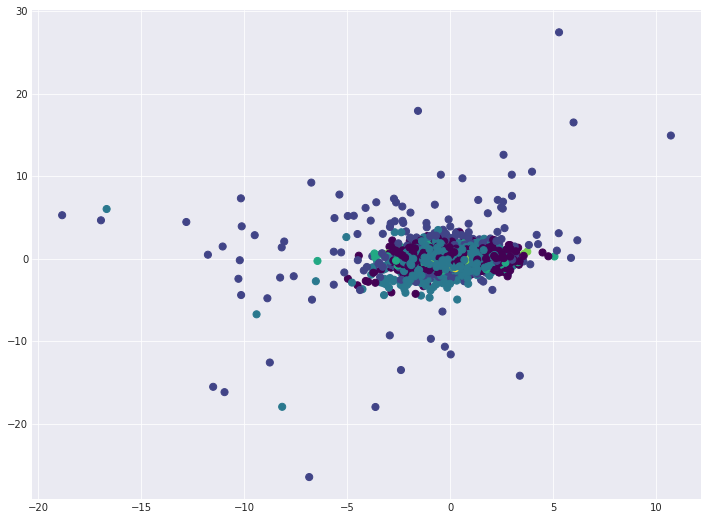

In [15]:
#your code here
plt.scatter(X_scaled_centered[:,0], X_scaled_centered[:,1], c=kmeans.labels_, s=50, cmap='viridis')

Выведите на экран значения метрик качества кластеризации

In [16]:
#your code here
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(y, kmeans.labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(y, kmeans.labels_))

Adjusted Rand-Index: 0.419
Adjusted mutual info score: 0.560


In [17]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y, kmeans.labels_))

Homogeneity: 0.540
Completeness: 0.581
V-measure: 0.560


In [18]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_scaled_centered, kmeans.labels_, sample_size=10000))

Silhouette Coefficient: 0.112


Теперь попробуем сделать кластеризацию с помощью AgglomerativeClustering (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [19]:
ag = AgglomerativeClustering(n_clusters=6, 
                             linkage='ward').fit(X_pca)

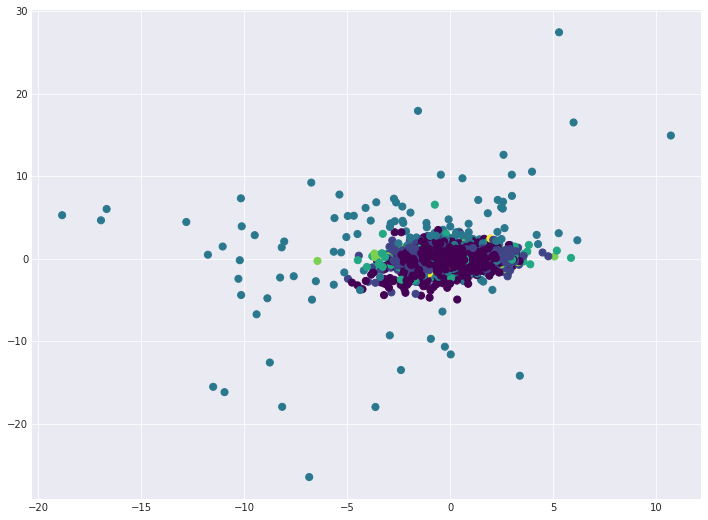

In [20]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=ag.labels_, s=50, cmap='viridis')

Выведите метрики качества для полученного разбиения на кластеры. Сравните с kmeans. Запишите выводы!

In [21]:
#your code here
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(y, ag.labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(y, ag.labels_))

Adjusted Rand-Index: 0.460
Adjusted mutual info score: 0.601


In [22]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, ag.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y, ag.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y, ag.labels_))

Homogeneity: 0.569
Completeness: 0.638
V-measure: 0.601


In [23]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_pca, ag.labels_, sample_size=10000))

Silhouette Coefficient: 0.117


Метод AgglomerativeClustering сработал лучше, чем Kmeans